In [1]:
import matplotlib.pyplot as plt
import numpy as np
from SocialNetwork.social_network_environment import *
from SocialNetwork.cascade import *
from Advertising.enviroment.bid import *
from Advertising.enviroment.VCG import *
from Advertising.learners.Greedy_algorithm import *
from Advertising.learners.GTS_Learner import *
from Advertising.learners.GTS_SW_Learner import *
from Advertising.learners.TS_no_qualities import *
from Advertising.learners.TS_no_anything import *
import math

from tqdm.autonotebook import tqdm
from Advertising.learners.TS_sliding_window import *
import itertools

arms = arms_creation(seed=30291, number_of_arms=20)

seed = 6789
random.seed(seed)
only_first = False


lambdas = [0.5, 0.42, 0.38, 0.30, 0.2, 0.05]
social_network = social_network_environment()
social_network.init_from_json(
    json_path_network='Config/network.json', json_path_features='Config/features.json')




with open("Config/estimated_influence.json", "r"):
    data = json.load(open("Config/estimated_influence.json"))

active_by_influence_reward = np.array(data.get("estimated_influence"))


In [2]:
def create_adv_bids():

    adversary_bids = []
    for _ in range(0, 10): 
        adversary_i_bids = []
        for _ in range(0, 5):
            adversary_i_bids.append(random.randint(0, 4))
        adversary_bids.append(adversary_i_bids)
    return adversary_bids

In [18]:

#initialization
n_try = 1
variance = 20
expected_values = []
interval = 5000
n_experiments=20000
sw_size = 2000
#sw_size = math.isqrt(n_experiments)

print(sw_size)
n_change = (int)(n_experiments/interval)
list_of_bids = []



for l in range(0, n_change):
    list_of_bids.append(create_adv_bids())

## we simulate a ts for the clairvoyant, as much as the change in adversary biddings







2000


In [4]:
#code for clairvoyant for only first position


# ts_only = [] 
# best_arm_indexes_only = []
# expected_values_list_only = []
# for r in range(0, n_change):
#     ts_only.append(GTS_Learner(20, arms, variance=variance,ad_id=1))
#     best, best_arm_index, _, expected_values, _ = ts(ts_only[r], arms, list_of_bids[r], only_first, interval, lambdas, social_network)
#     best_arm_indexes_only.append(best_arm_index)
#     print(best)
#     expected_values_list_only.append(expected_values)

In [5]:
# #code for clairvoyant all bids


# ts_all = []
# best_arm_indexes_all = []
# expected_values_list_all = []
# for r in range(0, n_change):
#     ts_all.append(GTS_Learner(20, arms, variance=variance,ad_id=1))
#     _, best_arm_index, _, expected_values, _ = ts(ts_all[r], arms, list_of_bids[r], only_first, n_experiments, lambdas, social_network)
#     best_arm_indexes_all.append(best_arm_index)
#     expected_values_list_all.append(expected_values)




In [6]:

exp_rewards_per_window=[]
vcg = VCG(lambdas)
i=0
for different in list_of_bids: #[[2, 1, 3, 4, 0], [3, 2, 1, 3, 4],...]
    i+=1
    all_bids=different
    all_exp_rewards=[]
    print("Interval"+ str(i))
    for arm in arms:
        print("Doing arm "+ str(arm))
        exp_reward=0
        all_bids.insert(0, arm)
        ad_allocation_list = setup(bids=all_bids, n_bids=5)
        best_allocation = vcg.all_best_allocations(ad_allocation_list, social_network)
        for j in range(0, len(best_allocation)):
                temp_allocation = []
                temp_allocation = best_allocation[j]
                for k in range(0, len(best_allocation[j])):
                    if temp_allocation[k].ad_id == 1 and k != 0:
                        temp_allocation[k].ad_id = None
                        best_allocation[j] = temp_allocation
        for i in range(1, interval+1):
            payments = vcg.payments(ad_allocation_list, best_allocation, social_network)
            active_nodes, total_reward = activate_cascade(social_network=social_network, ad_allocation_list=best_allocation, slot_prominence=deltas,learner_id=1)
            payments_tot = calculate_total_payment(payments, social_network.categories, active_nodes)
            reward = (total_reward-payments_tot) 
            reset_nodes(social_network)
            exp_reward = (exp_reward*(i-1) + reward)/i
        all_bids.pop(0)
        all_exp_rewards.append(exp_reward)
    best_for_window = max(all_exp_rewards)
    exp_rewards_per_window.append(best_for_window)
    print(exp_rewards_per_window)

Interval1
Doing arm [4 1 1 3 0]
Doing arm [3 3 4 2 3]
Doing arm [1 4 3 2 0]
Doing arm [1 3 3 1 4]
Doing arm [1 1 2 0 4]
Doing arm [2 4 4 3 0]
Doing arm [4 0 0 0 1]
Doing arm [2 1 3 0 4]
Doing arm [4 2 2 2 4]
Doing arm [0 4 3 3 1]
Doing arm [2 3 4 2 4]
Doing arm [2 2 3 3 4]
Doing arm [0 4 4 2 1]
Doing arm [4 2 3 4 0]
Doing arm [2 3 2 1 1]
Doing arm [1 4 4 2 3]
Doing arm [0 0 4 4 4]
Doing arm [0 0 1 4 0]
Doing arm [3 1 2 2 3]
Doing arm [3 4 3 3 0]
[1.7410699999999903]
Interval5001
Doing arm [4 1 1 3 0]
Doing arm [3 3 4 2 3]
Doing arm [1 4 3 2 0]
Doing arm [1 3 3 1 4]
Doing arm [1 1 2 0 4]
Doing arm [2 4 4 3 0]
Doing arm [4 0 0 0 1]
Doing arm [2 1 3 0 4]
Doing arm [4 2 2 2 4]
Doing arm [0 4 3 3 1]
Doing arm [2 3 4 2 4]
Doing arm [2 2 3 3 4]
Doing arm [0 4 4 2 1]
Doing arm [4 2 3 4 0]
Doing arm [2 3 2 1 1]
Doing arm [1 4 4 2 3]
Doing arm [0 0 4 4 4]
Doing arm [0 0 1 4 0]
Doing arm [3 1 2 2 3]
Doing arm [3 4 3 3 0]
[1.7410699999999903, 1.0815739999999772]
Interval5001
Doing arm [4 1 1 3 0]


In [21]:

exp_rewards_per_window2=[]
vcg = VCG(lambdas)
i=0
for different in list_of_bids: #[[2, 1, 3, 4, 0], [3, 2, 1, 3, 4],...]
    i+=1
    all_bids=different
    all_exp_rewards=[]
    print("Interval"+ str(i))
    for arm in arms:
        print("Doing arm "+ str(arm))
        exp_reward=0
        all_bids.insert(0, arm)
        ad_allocation_list = setup(bids=all_bids, n_bids=5)
        best_allocation = vcg.all_best_allocations(ad_allocation_list, social_network)
        
        for i in range(1, interval+1):
            payments = vcg.payments(ad_allocation_list, best_allocation, social_network)
            active_nodes, total_reward = activate_cascade(social_network=social_network, ad_allocation_list=best_allocation, slot_prominence=deltas,learner_id=1)
            payments_tot = calculate_total_payment(payments, social_network.categories, active_nodes)
            reward = (total_reward-payments_tot) 
            reset_nodes(social_network)
            exp_reward = (exp_reward*(i-1) + reward)/i
        all_bids.pop(0)
        all_exp_rewards.append(exp_reward)
    best_for_window = max(all_exp_rewards)
    exp_rewards_per_window2.append(best_for_window)
    print(exp_rewards_per_window2)
    

Interval1
Doing arm [4 1 1 3 0]
Doing arm [3 3 4 2 3]
Doing arm [1 4 3 2 0]
Doing arm [1 3 3 1 4]
Doing arm [1 1 2 0 4]
Doing arm [2 4 4 3 0]
Doing arm [4 0 0 0 1]
Doing arm [2 1 3 0 4]
Doing arm [4 2 2 2 4]
Doing arm [0 4 3 3 1]
Doing arm [2 3 4 2 4]
Doing arm [2 2 3 3 4]
Doing arm [0 4 4 2 1]
Doing arm [4 2 3 4 0]
Doing arm [2 3 2 1 1]
Doing arm [1 4 4 2 3]
Doing arm [0 0 4 4 4]
Doing arm [0 0 1 4 0]
Doing arm [3 1 2 2 3]
Doing arm [3 4 3 3 0]
[1.102350000000001]
Interval5001
Doing arm [4 1 1 3 0]
Doing arm [3 3 4 2 3]
Doing arm [1 4 3 2 0]
Doing arm [1 3 3 1 4]
Doing arm [1 1 2 0 4]
Doing arm [2 4 4 3 0]
Doing arm [4 0 0 0 1]
Doing arm [2 1 3 0 4]
Doing arm [4 2 2 2 4]
Doing arm [0 4 3 3 1]
Doing arm [2 3 4 2 4]
Doing arm [2 2 3 3 4]
Doing arm [0 4 4 2 1]
Doing arm [4 2 3 4 0]
Doing arm [2 3 2 1 1]
Doing arm [1 4 4 2 3]
Doing arm [0 0 4 4 4]
Doing arm [0 0 1 4 0]
Doing arm [3 1 2 2 3]
Doing arm [3 4 3 3 0]
[1.102350000000001, 1.8926385714285912]
Interval5001
Doing arm [4 1 1 3 0]
Do

In [22]:
import json
with open('Config/clairvoyants_sw.json', 'w') as file:
    to_write = {'clairvoyant_q_f_sw': exp_rewards_per_window, 'clairvoyant_q_a_sw': exp_rewards_per_window2}
    json.dump(to_write, file)

In [24]:
ts_learner = GTS_SW_Learner(20, arms, variance=variance, size_SW=sw_size, ad_id=1)
#ts_learner2 = GTS_SW_Learner(20, arms, variance=variance, size_SW=sw_size, ad_id=1)

thing_to_plot_only_mean = []

for j in range(0, n_try):
    print("This is TS number " + str(j))

    best_arm, best_arm_index, number_of_pulls, expected_values, thing_to_plot_only= test_sw(ts_learner, arms, list_of_bids, not only_first, n_experiments, lambdas, social_network, interval)
    #best_arm2, best_arm_index2, number_of_pulls2, expected_values2, thing_to_plot_all= test_sw(ts_learner2, arms, list_of_bids, not only_first, n_experiments, lambdas, social_network, interval)
    thing_to_plot_only_mean.append(thing_to_plot_only)
    print(best_arm)
# plotting_means = np.mean(thing_to_plot_only_mean, axis=0)
# print(plotting_means)
plotting_means_cum_sum = np.cumsum(np.mean(thing_to_plot_only_mean, axis=0))
#print(plotting_means_cum_sum)


This is TS number 0
[0 4 3 3 1]
[ 0.         -3.15       -5.005      ...  0.85855378  0.85809981
  0.85819041]
[ 0.00000000e+00 -3.15000000e+00 -8.15500000e+00 ...  1.66682642e+04
  1.66691223e+04  1.66699805e+04]


In [9]:

# print("THE BEST ARM FOR EXPERIMENT ONLY FIRST IS:",
#       arms[best_arm_index], "INDEX", best_arm_index)
# print("THE BEST ARM FOR EXPERIMENT total IS:",
#       arms[best_arm_index2], "INDEX", best_arm_index2)

# array = [i+1 for i in range(0, 20)]


# plt.figure(0)
# plt.errorbar(array, expected_values, yerr=(1/ts_learner.tau0), fmt='o')
# plt.figure(1)
# plt.errorbar(array, expected_values2, yerr=(1/ts_learner2.tau0), fmt='o')

# plt.show()




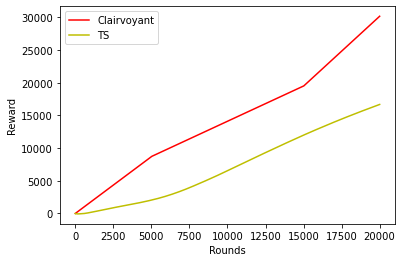

In [26]:

## Here i calculate the clairvoyant running the algorithm in a static enviroment as much as the times i vary the adversarial bids
#clairvoyant_only = []
clairvoyant_non_cum = []



for i in range(0, len(exp_rewards_per_window)):
    for j in range(0, interval):
        #clairvoyant_non_cum.append(expected_values_list_only[i][index])
        clairvoyant_non_cum.append(exp_rewards_per_window[i])

clairvoyant_cum = np.cumsum(clairvoyant_non_cum)

# for i in range(0, len(exp_rewards_per_window)):
#     if i==0:
#         value_cumulative = exp_rewards_per_window[i]
#         #value_cumulative = expected_values_list_only[i][index]
#     else:
#         value_cumulative += exp_rewards_per_window[i]
#         #value_cumulative += expected_values_list_only[i][index]
#     for j in range(0, interval):
#         clairvoyant_only.append(value_cumulative)
        


#the following three lines of code are to adjust the lenght of the clairvoyant to the lenght of the expected value array
# clairvoyant_only.append(expected_values_list_only[2][best_arm_indexes_only[2]])
# clairvoyant_only.append(expected_values_list_only[2][best_arm_indexes_only[2]])
# clairvoyant_only.append(expected_values_list_only[2][best_arm_indexes_only[2]])
# clairvoyant_only.append(expected_values_list_only[2][best_arm_indexes_only[2]])
# clairvoyant_only.append(expected_values_list_only[2][best_arm_indexes_only[2]])
#cum_sum_clairvoyant =np.cumsum(clairvoyant_only)
plt.figure(0)
plt.ylabel("Reward")
plt.xlabel("Rounds")
plt.plot(clairvoyant_cum, 'r')
plt.plot(plotting_means_cum_sum, 'y')
plt.legend(["Clairvoyant", "TS" ])

# plt.figure(1)
# plt.ylabel("Reward")
# plt.xlabel("Rounds")
# plt.plot(clairvoyant_non_cum, 'r')
# plt.plot(plotting_means_cum_sum, 'y')
# plt.legend(["Clairvoyant", "TS" ])
# print(plotting_means[:50])
# plotting_means[0]=0
# thing_to_plot_only[1]=0
# thing_to_plot_only[2]=0


# regret_only = []
# for i in range(0, len(plotting_means)):
#     regret_only.append(clairvoyant_only[i] - plotting_means[i])

# plt.figure(2)
# plt.ylabel("Regret")
# plt.xlabel("Rounds")
# plt.plot(regret_only, 'g')


In [ ]:
# clairvoyant_all = []

# for i,index in enumerate(best_arm_indexes_all):
#     for j in range(0, interval):
#         clairvoyant_all.append(expected_values_list_all[i][index])

# clairvoyant_all.append(expected_values_list_all[2][best_arm_indexes_all[2]])
# clairvoyant_all.append(expected_values_list_all[2][best_arm_indexes_all[2]])
# clairvoyant_all.append(expected_values_list_all[2][best_arm_indexes_all[2]])
# clairvoyant_all.append(expected_values_list_all[2][best_arm_indexes_all[2]])
# clairvoyant_all.append(expected_values_list_all[2][best_arm_indexes_all[2]])

        

# plt.figure(0)
# plt.ylabel("Reward")
# plt.xlabel("Rounds")
# plt.plot(clairvoyant_all, 'r')
# plt.plot(thing_to_plot_all, 'y')
# plt.legend(["Clairvoyant", "TS" ])


# regret_all = []
# for i in range(0, len(thing_to_plot_all)):
#     regret_all.append(clairvoyant_all[i] - thing_to_plot_all[i])




# plt.figure(1)
# plt.ylabel("Regret")
# plt.xlabel("Rounds")
# plt.plot(regret_all, 'g')



NameError: name 'best_arm_indexes_all' is not defined